In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import scipy.stats as stats
from scipy import stats
import statistics
import country_converter as coco

alpha = 0.05

In [2]:
# Загрузим получившийся DF 

data_upd = pd.read_csv('data/ds_salaries_upd.csv')

# Произведем преобразование признаков в категориальные 

for elem in data_upd.columns:
    if elem == 'salary_in_usd':
        pass
    else:
        data_upd['{}'.format(elem)] = data_upd['{}'.format(elem)].astype('category')


# Выведем информацию по DF и его признакам

display(data_upd.info())
display(data_upd.describe(exclude='int64'))
display(data_upd.describe(include='int64'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    category
 1   experience_level    565 non-null    category
 2   employment_type     565 non-null    category
 3   job_field           565 non-null    category
 4   salary_in_usd       565 non-null    int64   
 5   employee_residence  565 non-null    category
 6   remote_ratio        565 non-null    category
 7   company_location    565 non-null    category
 8   company_size        565 non-null    category
dtypes: category(8), int64(1)
memory usage: 10.3 KB


None

,work_year,experience_level,employment_type,job_field,employee_residence,remote_ratio,company_location,company_size
count,565,565,565,565,565,565,565,565
unique,3,4,4,3,6,3,6,3
top,2022,SE,FT,DS,America,100,America,M
freq,278,243,546,279,336,346,355,290


,salary_in_usd
count,565.000000
mean,110610.343363
std,72280.702792
min,2859.000000
25%,60757.000000
50%,100000.000000
75%,150000.000000
max,600000.000000


**Промежуточный вывод:**

В ходе предварительной обработки данных мы выяснили, что отсутствуют незаполненные признаки. Так же, обнаружили 42 дубликата и избавились от них. Так же, произвели очистку данных от неинформативных признаков, а именно: значение зарплаты и валюта зарплаты (salary, salary_currency). Причиной этому послужило наличие признака "salary_in_usd", который уже унифицирован для оценки уровня заработных плат сотрудников и его хватит для решения поставленных задач. 

Произвели преобразование признаков касательно стран, произвели укрупнение от страны к региону в части признаков нахождения компаний и резидентства работников, таким образом сведя значения признаков всего к 6 уникальным значениями. 

Так же, признак описания занимаемой должности тоже претерпел изменения в той части, что все значения свели к трем - к сферам деятельности работников: Data Science, Data Engineering и Data Analytics. 

Произвели преобразование типов данных признаков, и получили, что к числовым мы относим только заработную плату, остальные признаки относятся к категориальным. 

Воспользовавшись методом описательной статистики мы можем уже сделать ряд наблюдений: 

- Наиболее часто встречающийся регион расположения компаний и резидентства работников - Америка
- Наиболее часто встречающееся сфера деятельности - Data Science
- Предпочтительна постоянная занятость с удаленным режимом работы
- Превалируют компании среднего размера 
- Лидером в части зарплат по году является 2022 год, что уже подталкивает к мысли о том, что данных сектор IT сейчас находится на подъеме
- Что касается заработных плат, стоит отметить, что медианная зарплата хоть и отличается от средней, но не сильно (100.000 USD против 110.610 USD). При этом минимальный и максимальный размеры заработных плат очень сильно отличаются с медианным значением. Половина же всех заработных плат лежит в диапазоне 60.757 - 150.000 USD. 

# Визуальный анализ данных

____
## Анализ числового признака
**Уровень зароботной платы.**

Для данного признака построим гистограмму, а так же коробчатую диаграмму. Есть вероятность, что потребуется обработка выбросов.

C:\Users\nitys\AppData\Local\Temp\ipykernel_30000\4235818976.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


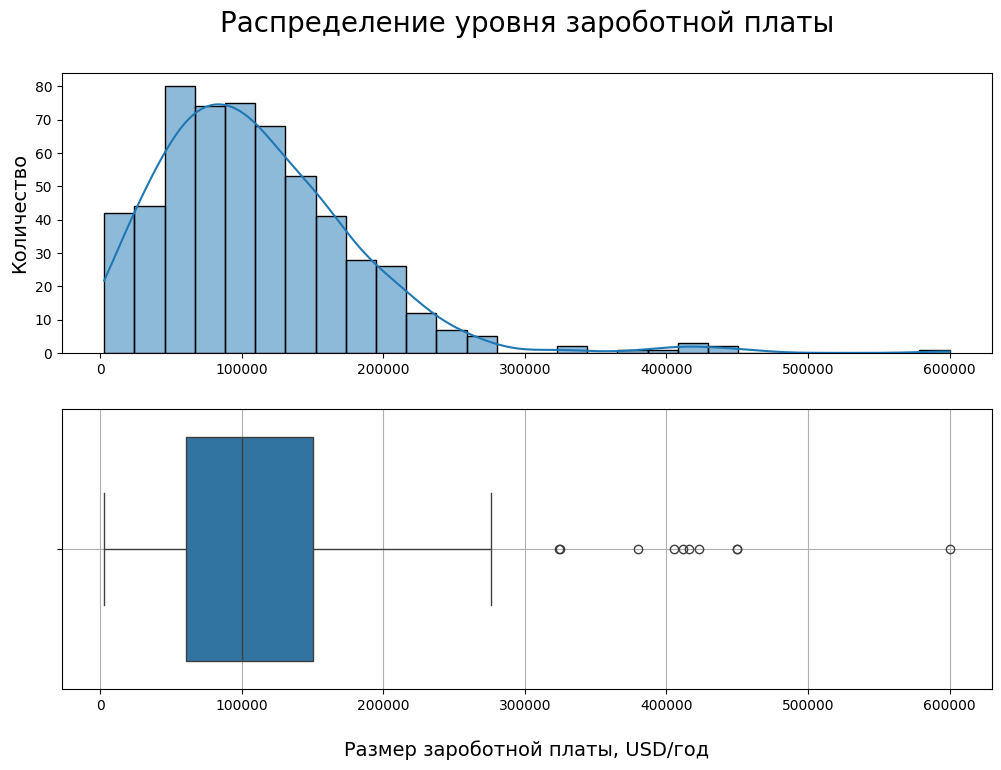

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.2)

salary_hist = sns.histplot(
    data=data_upd,
    x = 'salary_in_usd',
    kde = True,
    ax=axes[0]
    )

salary_hist.set_title('Распределение уровня зароботной платы''\n',
                      fontsize=20)
salary_hist.set_ylabel('Количество', fontsize = 14)
salary_hist.set_xlabel('')


salary_box = sns.boxplot(
    data = data_upd,
    x = 'salary_in_usd',
    orient='h',
    ax=axes[1], 
    )

salary_box.set_xlabel('\n''Размер зароботной платы, USD/год',
                       fontsize = 14)
salary_box.grid()

fig.show()

В результате построения коробчатой диаграммы мы наблюдаем ряд выбросов по уровню зароботной платы. 
Произведем выгрузку этих строк, для более детального изучения и принятия решения по ним.

In [4]:
iqr = data_upd['salary_in_usd'].quantile(0.75) - \
    data_upd['salary_in_usd'].quantile(0.25)

mustashe_right = iqr*3 + data_upd['salary_in_usd'].min()

display(data_upd[data_upd['salary_in_usd'] > mustashe_right])

,work_year,experience_level,employment_type,job_field,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
25,2020,EX,FT,DS,325000,America,100,America,L
33,2020,MI,FT,DS,450000,America,0,America,M
63,2020,SE,FT,DS,412000,America,100,America,L
93,2021,SE,FT,DE,276000,America,0,America,L
97,2021,MI,FT,DA,450000,America,100,America,L
157,2021,MI,FT,DS,423000,America,50,America,L
224,2021,EX,CT,DS,416000,America,100,America,S
251,2021,EX,FT,DE,600000,America,100,America,L
461,2022,EX,FT,DE,324000,America,100,America,M
498,2022,SE,FT,DS,380000,America,100,America,L


В целом, по предствленным данным можно сделать вывод, что они правдивы. 
Единственное, что может иметь смысл в их удалении - это привод к нормальности распределения признака, т.к. по построенной гистограмме наблюдаются очертания нормальности. 

Немного забегая вперед, проведем статистический тест на нормальность Шапиро-Уилка на этом этапе, для принятия решения, т.к. формируется датасет с которым будут производиться все последюущие действия. Проверку на нормальность распределения признака зарплаты произведем на уже очищенных от предполагаемых выбросов данных. 

In [9]:
# Создания копии DF для проверки, очистка его от выбросов 
 
data_drop_test = data_upd.copy()
index_to_drop = data_drop_test[data_drop_test['salary_in_usd'] > mustashe_right].index
data_drop_test = data_drop_test.drop(labels=index_to_drop, axis=0)


# Проведение теста Шапиро-Уилка

_, p = stats.shapiro(data_drop_test['salary_in_usd'])

print('p-value = %.3f' % (p))

if p <= alpha:
    print('Рапсределение не нормальное')
else: 
    print('Распределение нормальное')

H0 = 'Распределение не нормальное'
Ha = 'Распределение нормальное'

print((Ha, H0)[p<alpha])

p-value = 0.000
Рапсределение не нормальное
Распределение не нормальное


C:\Users\nitys\AppData\Local\Temp\ipykernel_30000\3005480352.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print((Ha, H0)[p<alpha])


По результатам проверок принято решение о **не удалении данных**. Выбросов не так много, и нельзя сказать, что это ошибочные данные. Даже сотрудник с заработной платой 600.000 USD может быть, т.к. имеет высокую квалификацию и занят в сфере Data Engineering. 
Просто, при будущем анализе будем иметь ввиду, что в нашем датасете имеются выбросы, и соответственно, **будем применять методы подходящие под данные с вероятными выбросами**. 

___
## Анализ категориальных признаков
Визульный анализ **категориальных признаков** проведем в два этапа. 

Сначала воспользуемся матрицей коррелиции признаков, это поможет нам обратить внимание на взаимосвязи признаков. 
Далее построим для признаков классические графики. 

### Кодирование и матрица корреляции

Для оценки влияния признаков друг на друга, применим матрицу корреляции. Т.к. почти все признаки наших данных являются категориальными, необходимо применить кодирование. 
Порядковому кодированию будут подвергнуты признаки опыта сотрудников и размер компании. Остальные признаки будут обработаны при помощи однократного кодирования.

C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtyp

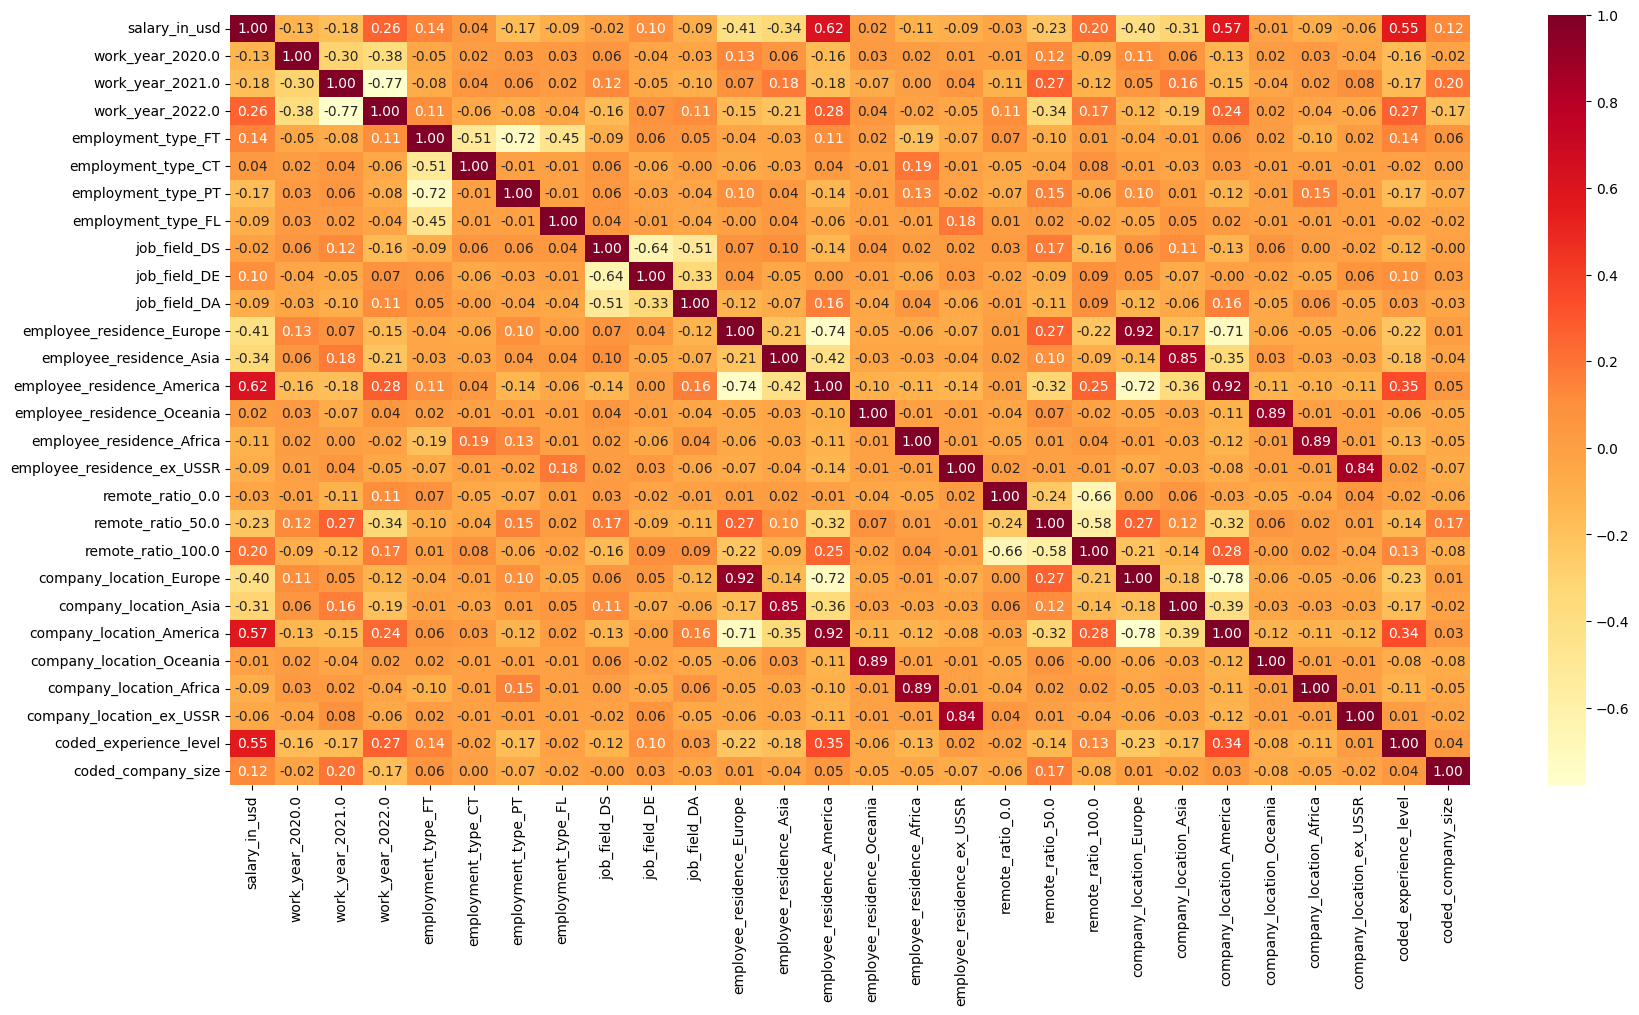

In [744]:
# Создадим новый DF, который будет по итогу представлять 
# только закодированные признаки /

data_encodered = data_upd.copy()

# Список для однократного кодирования
onehot_enc_list = ['work_year', 'employment_type', 
                   'job_field', 'employee_residence', 
                   'remote_ratio', 'company_location',]

# Список для порядкового кодирования и ключи кодирования
ordinal_enc_list = ['experience_level', 'company_size']
mapping_exp = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
mapping_size = {'S': 1, 'M': 2, 'L': 3}

# Цикл для однократного кодирования. Исходный признак удаляется. 
for elem in onehot_enc_list:
    encoder = ce.OneHotEncoder(cols=f'{elem}',
                               use_cat_names=True)
    data_bin = encoder.fit_transform(data_encodered[f'{elem}'])
    
    data_encodered = pd.concat([data_encodered, data_bin], axis=1)
    
    data_encodered = data_encodered.drop(f'{elem}', axis=1)

# Цикл для порядкого кодирования. Исходный признак удаляется. 
for elem in ordinal_enc_list:
    if elem == ordinal_enc_list[0]:
        encoder = ce.OrdinalEncoder(mapping=[{
            'col' : f'{elem}',
            'mapping' : mapping_exp 
            }])
    else:
        encoder = ce.OrdinalEncoder(mapping=[{
            'col' : f'{elem}',
            'mapping' : mapping_size 
            }])

    data_bin = encoder.fit_transform(data_encodered[[f'{elem}']])
    data_bin = pd.DataFrame(data_bin)
    
    data_bin = data_bin.rename(columns={ f'{elem}' : 'coded_' f'{elem}' } )
    
    data_encodered = pd.concat([data_encodered, data_bin], axis=1)
    data_encodered = data_encodered.drop(f'{elem}', axis=1)


# Визуализация взаимосвязи путем создания матрицы корреляции 
# При корреляции используем метод спирмена, т.к. имеем выбросы в 
# данных по зароботной плате /
fig = plt.subplots(figsize=(20,10))
fig = sns.heatmap(
    data_encodered.corr(
        method = 'spearman'), 
        annot=True,
        cmap='YlOrRd',
        fmt='.2f'
        )

___
**Благодаря построенной матрице корреляции мы можем сделать ряд наблюдений, которые в дальнейшем проверим при распределении различных признаков в разрезе уровня заработных плат в виде столбчатых диаграмм.**

Сразу стоит оговориться, что в данном анализе будут отступления от усредненных значений коэффициентов корреляций в части силы корреляции. По большинству признаков коэффициенты корреляции низки, однако, мы можем сравнить коэффициенты корреляции «внутри» одной группы признаков (как, например, режим работы сотрудника). 

Итак, что первое бросается в глаза, хоть это непосредственно и не относится к уровню заработных плат, так это **высокий уровень корреляции у географических признаков**: локация компании, резидентство сотрудника. Мы можем сделать предположение, что преимущественно, локация компании совпадает с резидентством сотрудника. Выделяются регионы бывшего СССР, Азии с более низким коэффициентом корреляции, что при детальном анализе может быть объяснено работой в компаниях Америки и Европы, что так же объяснит нам, почему на пересечении этих признаков (локация компании, локация сотрудника Америка / Европа) коэффициент не единица. **В дальнейшем построим график, иллюстрирующий данную зависимость.**

Далее будут приведены выводы в формате признак – краткое наблюдение. 

**Года**

В 2020 и 2021 году уровень заработных плат в сфере Data Science (далее – ЗП, подразумевается медианное значение признака), незначительно отличается, но в 2021 году все же имелся небольшой рост. 2022 год – уровень ЗП вырос более ощутимо. 

**Тип занятости**

Общие коэффициенты низки, и тяжело сделать конкретный вывод. Но, что можно сказать точно, что такой тип занятости как фриланс и частичная занятость приносят более низкие доходы в данной сфере, т.к. относительно других значений признаков, их зависимость отрицательная. 

**Сфера деятельности**

Специалисты в области Data Engineering имеют более высокие доходы. 

**Режим работы сотрудников**

Наиболее высокие ЗП наблюдаются при удаленном формате работы, далее, офисный и гибридный. Возможно, это связано с тем, что на удаленном формате работы заняты преимущественно сотрудники с более высокой квалификацией.

Наблюдается слабая связь признака гибридного режима работы с признаком года. **Построим график, визуализирующий это распределение.** 

**Регион нахождения головного офиса компании** 

Наблюдается средняя связь между признаком со значением Америки и уровнем заработных плат. Что подсказывает нам, что Америка является лидером по уровню ЗП. Интересна обратная связь уровня ЗП с признаком Европы, он отрицателен. Возможно, этот показатель объясняется большой разницей с зарплатами в Америке. 

Так же наблюдается, скажем, с натяжкой, слабая связь признака со значением "Европа" и режимом работы сотрудников "Габиридный". **Построим график, визуализирующий это распределение.** 

**Регион резидентства сотрудников** 

Лидером так же является Америка. Все распределение, что логично, соответствует распределению региона нахождения головного офиса компании. В целом, один из признаков, в случае создания модели, подлежит удалению, очевидно, они мультикоррелиальны. 

**Квалификация сотрудников** 

Признак имеет среднюю корреляцию с уровнем ЗП, следовательно, оказывает влияние на уровень ЗП. 

Так же признак имеет слабую связь с географическими признаками - локация компании и работника Америка. **Построим график, визуализирующий это распределение.** 

Почему важно заострить на этом внимание? Потому что, судя по всему, Америка является лидером по уровню ЗП, но, есть вероятность, что объяснение этому является то, что уровень квалификации представленных работников в этом регионе выше. Надо это проверить.

**Размер компании** 

Коэффициент корреляции говорит нам о том, что признак имеет очень слабую связь с уровнем ЗП.
Разберемся с этим в дальнейшем более детально.  

___

### Распределение режимов работы сотрудников по годам

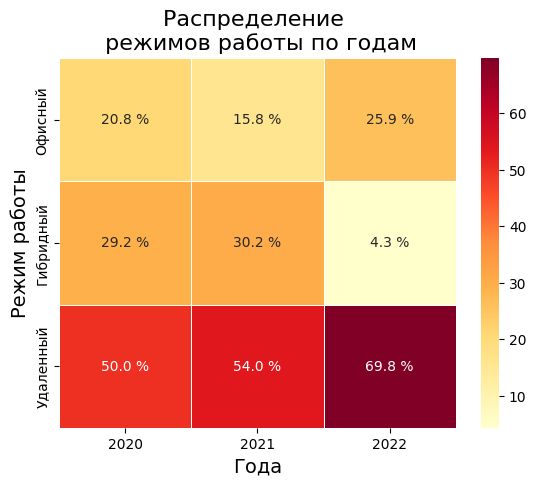

In [745]:
# Строим таблицу сопряженности для признаков режима работы 
# и года. Нормализуем данные по признаку года; 
# преобразуем таблицу в DF; 
# преобразуем значения в шкалу 0..100 /

data_remote_rat_year = pd.crosstab(
    index=data_upd['remote_ratio'],
    columns=data_upd['work_year'],
    normalize='columns'
)
data_remote_rat_year = pd.DataFrame(data_remote_rat_year)
data_remote_rat_year = data_remote_rat_year.apply(lambda x: x*100)


# Визуализируем полученный DF, делаем необходимые подписи,
# добавляем знак процента к значениям /

fig = sns.heatmap(
    data_remote_rat_year, 
    annot=True, 
    linewidth=.5, 
    fmt='.1f', 
    cmap="YlOrRd"
    )

fig.set_xlabel('Года', fontsize = 14)
fig.set_ylabel('Режим работы', fontsize = 14)
fig.set_yticklabels(['Офисный', 'Гибридный', 'Удаленный'])
for t in fig.texts: t.set_text(t.get_text() + " %")

plt.title('Распределение \n режимов работы по годам', fontsize = 16)

plt.show()

**Из полученной тепловой карты мы видим, что распространённость удаленного формата работы с годами растет, так же как и офисного. Гибридный же формат работы в 2022 году получил резкое сокращение.**

Имеется предположение, что данную картину объясняет пандемия COVID-19. Интересно было бы получить аналогичные данные по 2019 году для сравнения. Предположение заключается в том, что гибридный и удаленный формат работы получили распространение в результате ограничительных мер. В 2022 году, когда пандемия официально закончилась, произошло перераспределение сотрудников из гибридного режима на обратно в офисный формат, и в удаленный формат, т.к. он себя проявил с хорошей стороны.  

### Распределение режимов работы сотрудников по регионам нахождения компаний

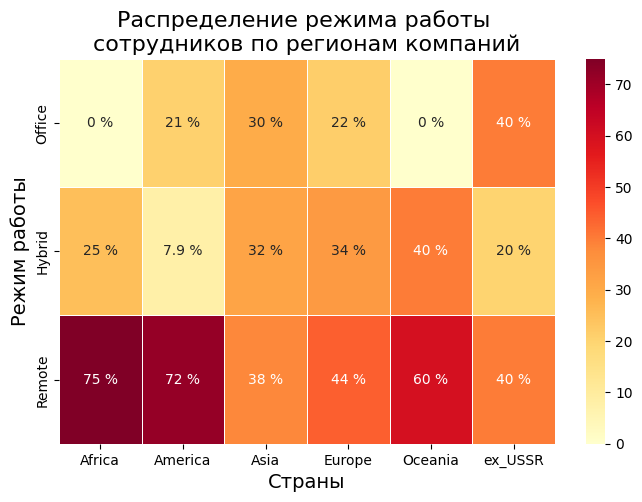

In [746]:
data_remote_rat_country = pd.crosstab(
    index = data_upd['remote_ratio'],
    columns = data_upd['company_location'],
    normalize='columns'
    )
data_remote_rat_country = data_remote_rat_country.apply(
    lambda x: round(x*100, 1)
    )

fig, axes = plt.subplots(figsize = (8,5))
fig = sns.heatmap(
    data_remote_rat_country,
    annot=True,
    linewidths=.5,
    cmap='YlOrRd',
    )
for t in fig.texts: t.set_text(t.get_text() + " %")

fig.set_yticklabels(['Office', 'Hybrid', 'Remote'])
fig.set_ylabel('Режим работы', fontsize = 14)
fig.set_xlabel('Страны', fontsize = 14)
fig.set_title('Распределение режима работы \n'
              'сотрудников по регионам компаний', 
              fontsize = 16
              )
plt.show()

**Из графика видно, что в Америке по трехлетней выборке преобладает удаленный формат работы, что очень контрастирует с данными по Европе, где значения признака распределены более равномерно.** 

Интересно оценить, является ли популярность удаленного формата работы следствием работы вне страны своей резиденции.

Для этого произведем соответствующую выборку и визуализацию.

C:\Users\nitys\AppData\Local\Temp\ipykernel_24612\3914596133.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_country = pd.pivot_table(


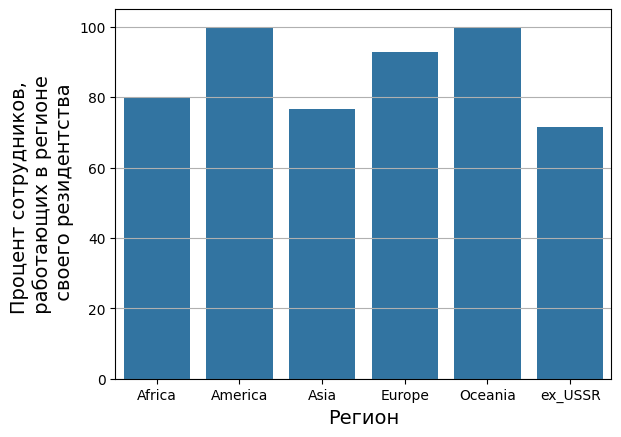

In [747]:
# Создаем сводну таблицк по географическим признакам, 
# в качестве values выбрали просто один из признаков, 
# т.к. будем применять агрегирующую функцию счета / 

data_country = pd.pivot_table(
    data_upd,
    columns='company_location',
    index = 'employee_residence',
    values='company_size',
    aggfunc='count'
    )


# Словарь, в него в ходе цикла будут вкладываться 
# ключ - регион, значение - процент сотрудников, работающих 
# в регионе своего резидентства /

company_empl_equal_dict = {}

# Список стран, используем далее в цикле

country_list = list(data_country.index)


# В цикле произведем расчет процента сотрудников, которые 
# работают в компаниях аналогичего с собой резидентства 
# Произведем деление значения "страна-страна", т.е. совпадания 
# резиденств на общее число сотрудников резиденства исследуемой страны /

for country in country_list:
    ratio = data_country.loc[f'{country}', f'{country}'] / \
        sum(data_country.loc[f'{country}'])*100
    ratio = round(ratio, 2)
    
    employees = sum(data_country.loc[f'{country}'])
    
    company_empl_equal_dict.update({f'{country}' : ratio})
    

# На основе словаря company_empl_equal_dict создаем DF

company_empl_equal_df = pd.DataFrame.from_dict(
    company_empl_equal_dict, 
    orient='index'
    )
company_empl_equal_df = company_empl_equal_df.reset_index()
company_empl_equal_df = company_empl_equal_df.rename(
    columns={'index': 'Region', 0:'Ratio'}
    )


# Визуализация созданного DF

fig = sns.barplot(company_empl_equal_df, x='Region', y='Ratio')

fig.set_ylabel(
    'Процент сотрудников, \n работающих в регионе \n своего резидентства',
    fontsize = 14
    )
fig.set_xlabel('Регион', fontsize = 14)
fig.grid(axis='y')

plt.show('png')

**Как и ожидалось, мы наблюдаем, что в странах Америки, Европы, Океании, очень высокий процент сотрудников, которые работают в компаниях стран своего резедентства.**
**Что же касается стран бывшего СССР, Азии и Африки, процент людей, работающих в компаниях стран своего резедентства, ниже 80 процентов.**

### Распределение уровня квалификации работников по регионам нахождения компаний

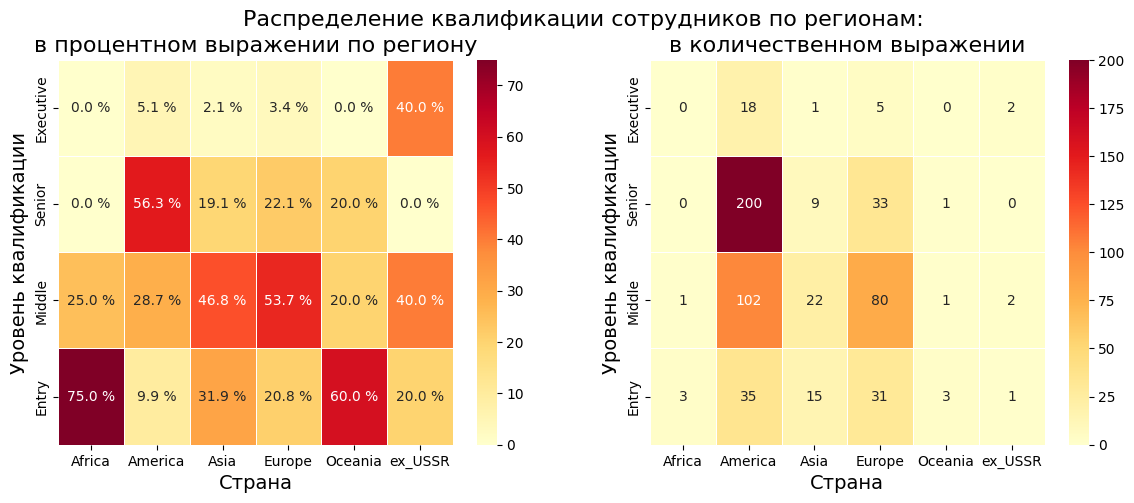

In [748]:
# Создаем subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

# Создаем таблицу сопряженности для признаков квалификации 
# и страны компании, делаем нормализацию по локации /
data_expr_location_norm = pd.crosstab(
    index=data_upd['experience_level'],
    columns=data_upd['company_location'],
    normalize='columns'
    )

data_expr_location_norm = pd.DataFrame(data_expr_location_norm)

# Поменяем местами строки для логичности от большего к меньшему, 
# приведем проценты к целочисленной форме шкалы 0-100 /

new_index = ['EX', 'SE', 'MI', 'EN']
data_expr_location_norm = data_expr_location_norm.reindex(new_index)

data_expr_location_norm = data_expr_location_norm.apply(lambda x: x*100)

# Создаем тепловую карту признаков, добавляем необходимые 
# обозначения, знак процента к значениям в тепловой карте /

fig = sns.heatmap(
    data_expr_location_norm, 
    annot=True, 
    linewidth=.5, 
    fmt='.1f', 
    cmap="YlOrRd",
    ax=axes[0]
    )

fig.set_xlabel('Страна', fontsize = 14)
fig.set_ylabel('Уровень квалификации', fontsize = 14)
fig.set_yticklabels(['Executive', 'Senior', 'Middle', 'Entry'])
for t in fig.texts: t.set_text(t.get_text() + " %")

fig.set_title('в процентном выражении по региону',
          fontsize = 16
          )


# Создаем таблицу сопряженности для признаков квалификации 
# и страны компании, нормализацию не делаем - признак количественный /

data_expr_location_count = pd.crosstab(
    index=data_upd['experience_level'],
    columns=data_upd['company_location']
    )
data_expr_location_count = pd.DataFrame(data_expr_location_count)


# Поменяем местами строки для логичности от большего к меньшему

new_index = ['EX', 'SE', 'MI', 'EN']
data_expr_location_count = data_expr_location_count.reindex(new_index)


# Создаем тепловую карту признаков, добавляем необходимые обозначения

fig = sns.heatmap(
    data_expr_location_count, 
    annot=True, 
    linewidth=.5, 
    fmt='.0f', 
    cmap="YlOrRd",
    ax=axes[1]
    )

fig.set_xlabel('Страна', fontsize = 14)
fig.set_ylabel('Уровень квалификации', fontsize = 14)
fig.set_yticklabels(['Executive', 'Senior', 'Middle', 'Entry'])

fig.set_title('в количественном выражении',
          fontsize = 16
          )


# Создаем общий для двух расперделений заголовок

plt.suptitle('Распределение квалификации сотрудников по регионам:',            
             fontsize = 16
             )

plt.show('png')

**Из полученных графиков мы видим, что страны Америки являются лидерами как по количественному, так и по процентному соотношению сотрудников квалификации Senior.**
**В странах Европы и Африки преобладающая квалификация - Middle специалист.**

___
### Выводы по отмеченным закономерностям

Выводы и наблюдения, приведенные по результатам построения матрицы корреляций в целом верны, повторять мы их не будем. Краткие выводы по конкретным связям признаков представлены к каждому графику. 

Единственное, что можно поправить в изначальных выводах, суммируя данные по полученным наблюдениям закономерностей, касается признака "Режим работы". 

Предположение о том, что более высокий уровень ЗП при удаленном режиме работы связан с тем, что квалификация сотрудников в этой области выше, верно частично. В ходе построения различных зависимостей, можно сказать, что это связано так же и с тем, что этот режим работы развит в Америке, которая является лидером по ЗП (но в то же время в Америке более высокая квалификация сотрудников). 
___

### Гистограммы и столбачатые графики распределения признаков по количеству и по медианному уровню заработных плат

Предварительно, для удобства дальнейшего изучения, создадим копию DF, в котором произведем замену значений признаков на легко читаемые с ясным отражением смысла значения признака. 

In [749]:
# Создаем копию DF, прописываем функции изменения значений 
# признаков и применяем их /

data_easy_read = data_upd.copy()

def exprnc_refill(x):
    if x == 'EN':
        return 'Entry'
    if x == 'MI':
        return 'Middle'
    if x == 'SE':
        return 'Senior'
    if x == 'EX':
        return 'Executive'

data_easy_read['experience_level'] = \
    data_easy_read['experience_level'].apply(exprnc_refill)
    

def empl_type_refill(x):
    if x == 'PT':
        return 'Partly'
    if x == 'FT':
        return 'Full-time'
    if x == 'CT':
        return 'Contract'
    if x == 'FL':
        return 'Freelance'
    
data_easy_read['employment_type'] = \
    data_easy_read['employment_type'].apply(empl_type_refill)
    

def remote_ratio_refill(x):
    if x == 0:
        return 'In-office'
    if x == 50:
        return 'Hybrid'
    if x == 100:
        return 'Remote'
    
data_easy_read['remote_ratio'] = \
    data_easy_read['remote_ratio'].apply(remote_ratio_refill)


def company_size_refill(x):
    if x == 'S':
        return '< 50 employees'
    if x == 'M':
        return '50 - 250 employees'
    if x == 'L':
        return '> 250 employees'
    
data_easy_read['company_size'] = \
    data_easy_read['company_size'].apply(company_size_refill)


На основе полученных преобразованных данных построим графики

Для удобства анализа ниже построены графики двух типов. 

Первый - распределение признаков по количеству их представления в данных, второй - распределение признаков в разрезе медианного уровня заработных плат. 

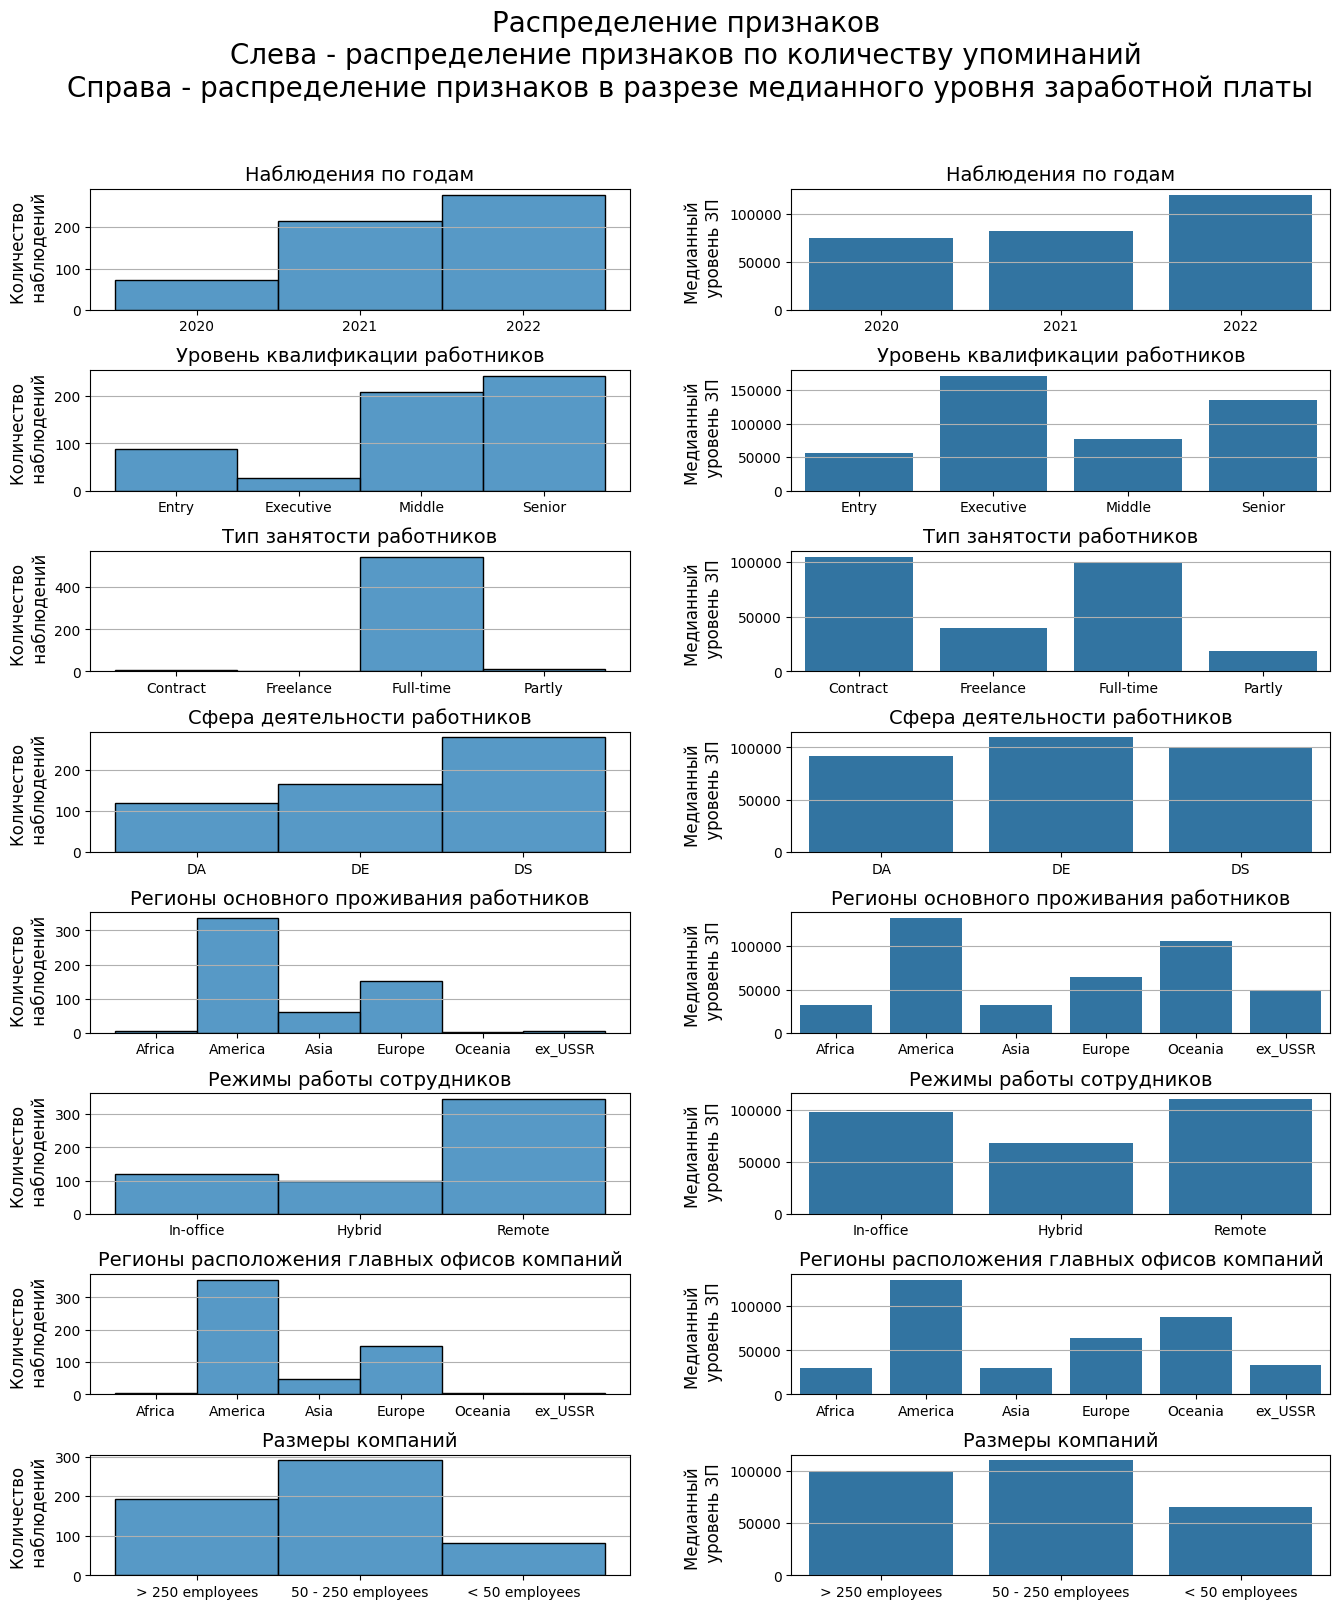

In [750]:
fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (16, 18))
plt.subplots_adjust(hspace=0.5, wspace = 0.3)

# Список, который будет импортировать как названия графиков
title_list = ['Наблюдения по годам',
             'Уровень квалификации работников',
             'Тип занятости работников',
             'Сфера деятельности работников',
             'Регионы основного проживания работников',
             'Режимы работы сотрудников',
             'Регионы расположения главных офисов компаний',
             'Размеры компаний'
             ]

# Список названий колонок, по которым будут работать циклы
cols_list = list(data_upd.columns)
cols_list.remove('salary_in_usd')

# Счетчик для цикла создания гистограмм
counter_hist = 0

# Цикл создания гистограмм
for elem in cols_list:
    hist = sns.histplot(
        data_easy_read,
        x='{}'.format(elem),
        ax=axes[counter_hist][0],
        )
    
    hist.set_xlabel('')
    hist.set_ylabel('Количество \n наблюдений', fontsize = 12)
    hist.set_title(f'{title_list[counter_hist]}', fontsize = 14)
    hist.grid(axis='y', which='major')
    
    # Для признака года пропишем, что будет выводиться на график
    if counter_hist == 0:
        hist.set_xticks([2020,2021,2022])
    
    counter_hist+=1


# Счетчик для цикла создания столбатых графиков
counter_bar = 0    

# Цикл создания столбатых графиков
for elem in cols_list:
    bar = sns.barplot(
        data_easy_read,
        x=f'{elem}',
        y='salary_in_usd',
        estimator='median',
        ax=axes[counter_bar][1],
        errorbar=None
        )
    
    bar.set_xlabel('')
    bar.set_ylabel('Медианный \n уровень ЗП', fontsize = 12)
    bar.set_title(f'{title_list[counter_bar]}', fontsize = 14)
    bar.grid(axis='y')
   
    counter_bar+=1

# Название группы графиков
fig.suptitle('Распределение признаков \n'
             'Слева - распределение признаков по количеству упоминаний \n'
             'Справа - распределение признаков в разрезе медианного уровня '
             'заработной платы',
            fontsize = 20
            )

plt.show('png')


Из визулизируемых распределений, мы может дать ответ на один исходный вопрос. 

**У специалиистов Data Science наблюдается ежегодный рост заработных плат.**



In [751]:
data_upd[data_upd['employee_residence'] == 'Oceania']

,work_year,experience_level,employment_type,job_field,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
9,2020,SE,FT,DE,125000,Oceania,50,Oceania,S
482,2022,MI,FT,DS,87425,Oceania,100,Oceania,L
484,2022,EN,FT,DS,86703,Oceania,50,Oceania,M
489,2022,EN,FT,DS,150000,Oceania,100,Oceania,S


In [752]:
# функция для принятия решения о нормальности

def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы

def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

___
### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

#### Проверка нормальности распределения

Проведем проверку на нормальность распределения значений признака зарплаты для каждого года. 

Воспользуемся методом Шапиро-Уилка. 

In [753]:
# Создадием объекты series со значениями признака зарплат по годам / 

data_2020 = data_upd.loc[data_upd['work_year'] == 2020, 'salary_in_usd']
data_2021 = data_upd.loc[data_upd['work_year'] == 2021, 'salary_in_usd']
data_2022 = data_upd.loc[data_upd['work_year'] == 2022, 'salary_in_usd']


# Прроведем тест на нормальность, выведем полученные данные на экран /

print('Распределение заработных плат в 2020 году')
result = stats.shapiro(data_2020)
decision_normality(result[1])

print('\nРаспределение заработных плат в 2021 году')
result = stats.shapiro(data_2021)
decision_normality(result[1])

print('\nРаспределение заработных плат в 2022 году')
result = stats.shapiro(data_2022)
decision_normality(result[1])

Распределение заработных плат в 2020 году
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Распределение заработных плат в 2021 году
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Распределение заработных плат в 2022 году
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


#### Статистический тест

Так как вопрос стоит именно в динамике (увеличении зарплат), а в нашем датасете присутствует три года, произведем тесты на статистическую значимость год к году. 
Наши данные распределены не нормально, они не зависимы, две группы, итого, **воспользуемся методом Манна-Уитни.** 

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза:* зарплата с годом не меняется, либо больше, чем в следующем году.
$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза:* Зарплата растет с годами. 
$$ H_1 : μ_1 < μ_2$$

In [754]:
_, p = stats.mannwhitneyu(data_2021, data_2020, alternative='greater')
decision_hypothesis(p)

_, p = stats.mannwhitneyu(data_2022, data_2021, alternative='greater')
decision_hypothesis(p)


p-value = 0.249
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

У нас нет оснований утверждать, что заработная плата в 2021 году выше, чем в 2020. 

Но, мы можем утверждать, что заработная плата в 2022 году выше, чем в 2021.

___
### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Первым этапом ответим на вопрос отличаются ли зарплаты специалистов. Если отличаются, вторым этапом ответим на вопрос в какую сторону.

#### Проверка нормальности распределения

Проведем проверку на нормальность распределения значений признака зарплаты для каждой сферы деятельности за 2022 год. 

Воспользуемся методом Шапиро-Уилка. 

In [755]:
# Создаем два объекта series с соответствующими данными

data_ds_salary = data_upd[data_upd['work_year'] == 2022]. \
    loc[data_upd['job_field'] == 'DS', 'salary_in_usd']

data_de_salary = data_upd[data_upd['work_year'] == 2022]. \
    loc[data_upd['job_field'] == 'DE', 'salary_in_usd']
    

# Тест на нормальность, вывод результатов

print('Распределение заработных плат в 2022 году для Data Scientists')
result = stats.shapiro(data_ds_salary)
decision_normality(result[1])

print('\nРаспределение заработных плат в 2022 году для Data Engineers')
result = stats.shapiro(data_de_salary)
decision_normality(result[1])

Распределение заработных плат в 2022 году для Data Scientists
p-value = 0.018
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Распределение заработных плат в 2022 году для Data Engineers
p-value = 0.013
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


#### Статистический тест

Имеем две группы, они независимы, распределены не нормально. **Воспользуемся методом Манна - Уитни.**


**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: размер заработных плат специалистов в области Data Science и Data engineering в 2022 год не отличается.

$$ H_0 : μ_1 = μ_2 $$

*Альтернативная гипотеза*: размер заработных плат специалистов в области Data Science и Data engineering в 2022 год отличается.

$$ H_1 : μ_1 \neq μ_2 $$

In [756]:
_, p = stats.mannwhitneyu(data_ds_salary, data_de_salary, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.787
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**

У нас нет оснований утверждать, что заработная плата специалистов в области Data Science и Data Engineering отличается в 2022 году.

___

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

#### Проверка нормальности распределения

Проведем проверку на нормальность распределения значений признака зарплаты специалиста Data Scientist для каждого размера компаний. 

Воспользуемся методом Шапиро-Уилка. 

In [757]:
# Создадием объекты series со значениями признака зарплат по компаниям /

data_company_s = data_upd.loc[
    data_upd['company_size'] == 'S', 'salary_in_usd'
    ]
data_company_m = data_upd.loc[
    data_upd['company_size'] == 'M', 'salary_in_usd'
    ]
data_company_l = data_upd.loc[
    data_upd['company_size'] == 'L', 'salary_in_usd'
    ]


# Проведем тест на нормальность, выведем полученные данные на экран /

print('Распределение заработных плат Data Scientist в S-компаниях')
result = stats.shapiro(data_company_s)
decision_normality(result[1])

print('\nРаспределение заработных плат Data Scientist в M-компаниях')
result = stats.shapiro(data_company_m)
decision_normality(result[1])

print('\nРаспределение заработных плат Data Scientist в L-компаниях')
result = stats.shapiro(data_company_l)
decision_normality(result[1])

Распределение заработных плат Data Scientist в S-компаниях
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Распределение заработных плат Data Scientist в M-компаниях
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Распределение заработных плат Data Scientist в L-компаниях
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


#### Статистический тест

Имеем три группы, они независимы, распределены не нормально. **Воспользуемся методом Краскелла-Уоллиса**


**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: размер заработных плат специалистов Data Scientist одинаков в компаниях разного размера.

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработных плат специалистов Data Scientist различается в компаниях разного размера.

$$ H_1 : μ_1 \neq μ_2 \neq μ_2 $$

In [758]:
_, p = stats.kruskal(data_company_s, data_company_m, data_company_l)
decision_hypothesis(p)


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод:**

Мы получили результат, что зарплаты отличаются в зависимости от размеров компании. 

Соответственно, чтобы полностью ответить на вопрос, произведем сравнение трех выборок попарно. 

Для начала произведем сравнение для ответа на вопрос о схожести / не схожести зарплат в компаниях. 

Имеем две группы, они независимы, распределены не нормально. **Воспользуемся методом Манна - Уитни**


**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: размер заработных плат специалистов Data Scientist одинаков в компаниях разного размера.

$$ H_0 : μ_1 = μ_2 $$

*Альтернативная гипотеза*: размер заработных плат специалистов Data Scientist различается в компаниях разного размера.

$$ H_1 : μ_1 \neq μ_2 $$

In [759]:
print('Сравнение зарплат в компаниях размера M и S')
_, p = stats.mannwhitneyu(data_company_m, data_company_s)
decision_hypothesis(p)

print('\nСравнение зарплат в компаниях размера L и S')
_, p = stats.mannwhitneyu(data_company_l, data_company_s)
decision_hypothesis(p)

print('\nСравнение зарплат в компаниях размера L и M')
_, p = stats.mannwhitneyu(data_company_l, data_company_m)
decision_hypothesis(p)

Сравнение зарплат в компаниях размера M и S
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.

Сравнение зарплат в компаниях размера L и S
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.

Сравнение зарплат в компаниях размера L и M
p-value = 0.317
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Мы выяснили, что зарплаты в компаниях **M / S** и в **L / S** не равны, разберемся подробнее. 

Сделаем еще один тест. Сравним зарплаты в компаниях **M / S**. Вывод будет пременим так же и для сравнения **L / S**, т.к. зарплаты в L и M равны. 

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: размер заработных плат специалистов Data Scientist в компаниях размера **S** больше или равен зараплате специалистов в компаниях **M**.

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза*: размер заработных плат специалистов Data Scientist в компаниях размера **S** меньше зараплате специалистов в компаниях **M**.

$$ H_1 : μ_1 < μ_2 $$

In [760]:
print('Сравнение зарплат в компаниях размера M и S')
_, p = stats.mannwhitneyu(data_company_m, data_company_s, alternative='greater')
decision_hypothesis(p)

Сравнение зарплат в компаниях размера M и S
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

У нас нет оснований утверждать, что заработная плата в компаниях размера **L** и **M** различаются. 

Но, мы можем утверждать, что зарплаты в компаниях размера **S** меньше, чем в средних и больших компаниях.


___
# Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Отметим сразу, что данные признаки, анализ которых нам необходимо произвести являются категориальными. Нам необходима **таблица сопряженности** признаков.

In [761]:
# Создадим таблицу сопряженности для признаков и выведем на экран

field_size_df = pd.crosstab(
    index=data_upd[data_upd['job_field'] != 'DA']['job_field'],
    columns=data_upd['company_size']
)

display(field_size_df)

company_size,L,M,S
job_field,,,
DE,54,97,15
DS,107,116,56


#### Преобразование данных

Такие данные нам не подойдут. Очевидно, что тест покажет наличие взаимосвязи, ввиду того, что численные (суммарные) значения по индексу DS больше. 

Там требуется преобразовать данные, **произвести шкалирование**. 

Стандартные библиотечные методы в данном случае не подойдут. Поступим следующим образом. Каждое значение признака (**DE и DS**) разделим на количество всего упоминаний по **DE** и по **DS** (для каждого свой). Таким образом, мы перейдем в шкалу [0...1], отражающую процент сотрудников, работающих в определенной сфере в разрезе размера компании. 


In [762]:
# Преобраззуем значения ячеек строк 
# делением значения на сумму строки /

field_size_df.loc['DE'] = field_size_df.loc['DE'].apply(
    lambda x: round(x/field_size_df.loc['DE'].sum(), 2)
    )

field_size_df.loc['DS'] = field_size_df.loc['DS'].apply(
    lambda x: round(x/field_size_df.loc['DS'].sum(), 2)
    )

display(field_size_df)


_, p, _, _ = stats.chi2_contingency(field_size_df)
decision_hypothesis(p)

C:\Users\nitys\AppData\Local\Temp\ipykernel_24612\3068573461.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  field_size_df.loc['DE'] = field_size_df.loc['DE'].apply(
C:\Users\nitys\AppData\Local\Temp\ipykernel_24612\3068573461.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.58' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  field_size_df.loc['DE'] = field_size_df.loc['DE'].apply(
C:\Users\nitys\AppData\Local\Temp\ipykernel_24612\3068573461.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  field_size_df

company_size,L,M,S
job_field,,,
DE,0.33,0.58,0.09
DS,0.38,0.42,0.20


p-value = 0.965
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


#### Статистический тест

Для исследования зависимости воспользуемся критерием Хи-Квадрат, т.к. имеем две группы из одной выборки, данные категориальные. 

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: между сферой деятельности и размером компании нет взаимосвязи. Признаки независимы.

*Альтернативная гипотеза*: между сферой деятельности и размером компании есть взаимосвязь. Признаки зависимы.

In [766]:
# проводим тест

_, p, _, _ = stats.chi2_contingency(field_size_df)
decision_hypothesis(p)

p-value = 0.965
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**

Взаимосвязи между наличием должностей Data Scientist и Data Engineer и размером компании **не выявлено**. 
___

In [764]:
data_upd[data_upd['employee_residence'] == 'Europe']['experience_level'].value_counts(normalize=True)

counry_exp_sal_df = pd.DataFrame(data_upd.groupby(['company_location', 'experience_level'])['salary_in_usd'].median())
counry_exp_df = pd.DataFrame(data_upd.groupby('company_location')['experience_level'].value_counts(normalize=True))
display(counry_exp_sal_df)
counry_exp_df

C:\Users\nitys\AppData\Local\Temp\ipykernel_24612\1299804436.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counry_exp_sal_df = pd.DataFrame(data_upd.groupby(['company_location', 'experience_level'])['salary_in_usd'].median())
C:\Users\nitys\AppData\Local\Temp\ipykernel_24612\1299804436.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counry_exp_df = pd.DataFrame(data_upd.groupby('company_location')['experience_level'].value_counts(normalize=True))


salary_in_usd
company_location experience_level               
Africa           EN                      10000.0
                 EX                          NaN
                 MI                      50000.0
                 SE                          NaN
America          EN                      80000.0
                 EX                     208000.0
                 MI                     107630.0
                 SE                     144927.0
Asia             EN                      21637.0
                 EX                      79039.0
                 MI                      25313.5
                 SE                      66265.0
Europe           EN                      49268.0
                 EX                     130026.0
                 MI                      62058.0
                 SE                      87932.0
Oceania          EN                      86703.0
                 EX                          NaN
                 MI                      87425.0
                 SE                     125000.0
ex_USSR          EN                      13400.0
                 EX                     157500.0
                 MI                      25487.0
                 SE                          NaN

proportion
company_location experience_level            
Africa           EN                  0.750000
                 MI                  0.250000
                 EX                  0.000000
                 SE                  0.000000
America          SE                  0.563380
                 MI                  0.287324
                 EN                  0.098592
                 EX                  0.050704
Asia             MI                  0.468085
                 EN                  0.319149
                 SE                  0.191489
                 EX                  0.021277
Europe           MI                  0.536913
                 SE                  0.221477
                 EN                  0.208054
                 EX                  0.033557
Oceania          EN                  0.600000
                 MI                  0.200000
                 SE                  0.200000
                 EX                  0.000000
ex_USSR          EX                  0.400000
                 MI                  0.400000
                 EN                  0.200000
                 SE                  0.000000

In [765]:
data_upd[data_upd['employee_residence'] == 'America']['experience_level'].value_counts(normalize=True)


experience_level
SE    0.580357
MI    0.267857
EN    0.101190
EX    0.050595
Name: proportion, dtype: float64